In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import datetime
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


import scipy
from scipy import hstack


from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
#from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression

**Loading data**

In [2]:
df_train = pd.read_csv('train_final.csv')

df_test = pd.read_csv('test_final.csv')

In [3]:
print('Shape of train data: ', df_train.shape)

print('Shape of test data: ', df_test.shape)

Shape of train data:  (1481075, 59)
Shape of test data:  (693359, 58)


In [4]:
df_train.head()

,train_id,item_condition_id,brand_name,price,shipping,gencat_name,subcat1_name,subcat2_name,preprocessed_name,preprocessed_description,...,gencat_mean_price,subcat1_mean_price,subcat2_mean_price,condition_mean_price,brand_median_price,name_median_price,gencat_median_price,subcat1_median_price,subcat2_median_price,condition_median_price
0,0,3,missing,10.0,1,Men,Tops,Tshirts,mlb cincinnati reds t shirt size xl,no description yet,...,34.734940,19.014216,18.368301,26.557241,14.0,15.5,21.0,14.0,14.0,16.0
1,1,3,Razer,52.0,0,Electronics,ComputersTablets,ComponentsParts,razer blackwidow chroma keyboard,this keyboard great condition works like came ...,...,35.190558,87.970533,42.913900,26.557241,39.5,40.0,15.0,40.0,25.0,16.0
2,2,1,Target,10.0,1,Women,TopsBlouses,Blouse,ava viv blouse,adorable top hint lace key hole back the pale ...,...,28.902679,18.249287,15.671262,26.499502,12.0,14.0,19.0,14.0,12.0,18.0
3,3,1,missing,35.0,1,Home,HomeDcor,HomeDcorAccents,leather horse statues,new tags leather horses retail rm stand foot h...,...,24.551068,21.581724,22.203802,26.499502,14.0,17.0,18.0,16.0,16.0,18.0
4,4,1,missing,44.0,0,Women,Jewelry,Necklaces,24k gold plated rose,complete certificate authenticity,...,28.902679,27.516272,25.597873,26.499502,14.0,18.0,19.0,14.0,12.0,18.0


In [5]:
df_test.head()

,test_id,item_condition_id,brand_name,shipping,gencat_name,subcat1_name,subcat2_name,preprocessed_name,preprocessed_description,name_first,...,gencat_mean_price,subcat1_mean_price,subcat2_mean_price,condition_mean_price,brand_median_price,name_median_price,gencat_median_price,subcat1_median_price,subcat2_median_price,condition_median_price
0,0,1,missing,1,Women,Jewelry,Rings,breast cancer i fight like a girl ring,size 7,breast,...,28.902679,27.516272,32.960560,26.499502,14.0,10.0,19.0,14.0,15.0,18.0
1,1,1,missing,1,Other,Officesupplies,ShippingSupplies,25 pcs new 7 5 x12 kraft bubble mailers,25 pcs new 7 5 x12 kraft bubble mailers lined ...,25,...,20.819917,16.719531,11.275820,26.499502,14.0,8.0,14.0,11.0,9.0,18.0
2,2,1,Coach,1,VintageCollectibles,BagsandPurses,Handbag,coach bag,brand new coach bag bought rm coach outlet,coach,...,27.345891,61.810448,139.664714,26.499502,31.0,29.0,16.0,28.0,55.5,18.0
3,3,2,missing,0,Women,Sweaters,Cardigan,floral kimono,floral kimono never worn lightweight perfect h...,floral,...,28.902679,26.299720,26.934284,27.584015,14.0,13.0,19.0,20.0,17.0,17.0
4,4,3,missing,1,Other,Books,ReligionSpirituality,life after death,rediscovering life loss loved one tony cooke p...,life,...,20.819917,16.209066,13.358423,26.557241,14.0,16.0,14.0,11.0,11.0,16.0


###  Train, Test split for cross validation

In [6]:
y = np.log1p(df_train['price'])
X=df_train.drop(['price'], axis=1)

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_cv , y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train size: {}, CV size: {}, Test size: {}' .format(x_train.shape, x_cv.shape, df_test.shape))

Train size: (1184860, 58), CV size: (296215, 58), Test size: (693359, 58)


###  Categorical features

* One-hot encoding of brand_name, gencat_name, subcat1_name, subcat2_name.


In [8]:
import re

def clean_category(categorical_values):
    '''takes categorical column values as arguments and returns list of cleaned categories'''
    
    catogories = list(categorical_values)

    categorical_values_list = []
    for i in tqdm(catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        categorical_values_list.append(i.strip())
    
    return categorical_values_list 

In [9]:
#Cleaning brand name before using count vectorizer
# Using same preprocessing as used earlier for categories: 'clean_cat()' function

x_train['brand_name'] = clean_category(x_train['brand_name'].values)

x_cv['brand_name'] = clean_category(x_cv['brand_name'].values)

df_test['brand_name'] = clean_category(df_test['brand_name'].values)

100%|██████████████████████████████████████████████████████████████████████| 693359/693359 [00:01<00:00, 396106.12it/s]


In [10]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(x_train['brand_name'].values)

train_brand_oneHot = vectorizer.transform(x_train['brand_name'].values)

cv_brand_oneHot = vectorizer.transform(x_cv['brand_name'].values)

test_brand_oneHot = vectorizer.transform(df_test['brand_name'].values)

print("Shape of matrices after one hot encoding")

print(train_brand_oneHot.shape, "\n", cv_brand_oneHot.shape  ,"\n", test_brand_oneHot.shape)

Shape of matrices after one hot encoding
(1184860, 4509) 
 (296215, 4509) 
 (693359, 4509)


In [11]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(x_train['gencat_name'].values)

train_gencat_oneHot = vectorizer.transform(x_train['gencat_name'].values)

cv_gencat_oneHot = vectorizer.transform(x_cv['gencat_name'].values)

test_gencat_oneHot = vectorizer.transform(df_test['gencat_name'].values)

print("Shape of matrices after one hot encoding")

print(train_gencat_oneHot.shape, "\n", cv_gencat_oneHot.shape, "\n", test_gencat_oneHot.shape)

Shape of matrices after one hot encoding
(1184860, 11) 
 (296215, 11) 
 (693359, 11)


In [12]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(x_train['subcat1_name'].values)

train_subcat1_oneHot = vectorizer.transform(x_train['subcat1_name'].values)

cv_subcat1_oneHot = vectorizer.transform(x_cv['subcat1_name'].values)

test_subcat1_oneHot = vectorizer.transform(df_test['subcat1_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat1_oneHot.shape, "\n", cv_subcat1_oneHot.shape, "\n", test_subcat1_oneHot.shape)

Shape of matrices after one hot encoding
(1184860, 114) 
 (296215, 114) 
 (693359, 114)


In [13]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(x_train['subcat2_name'].values)

train_subcat2_oneHot = vectorizer.transform(x_train['subcat2_name'].values)

cv_subcat2_oneHot = vectorizer.transform(x_cv['subcat2_name'].values)

test_subcat2_oneHot = vectorizer.transform(df_test['subcat2_name'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat2_oneHot.shape, "\n", cv_subcat2_oneHot.shape, "\n", test_subcat2_oneHot.shape)

Shape of matrices after one hot encoding
(1184860, 860) 
 (296215, 860) 
 (693359, 860)


### Tfidf vectorization on text features

* 1-3 grams of name<br>

* 1-3 grams of item_description

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=250000)
vectorizer.fit(x_train['preprocessed_name'].values)

train_name_tfidf = vectorizer.transform(x_train['preprocessed_name'].values)

cv_name_tfidf = vectorizer.transform(x_cv['preprocessed_name'].values)

test_name_tfidf = vectorizer.transform(df_test['preprocessed_name'].values.astype('U'))

print("Shape of matrices after vectorization")
print(train_name_tfidf.shape, "\n", cv_name_tfidf.shape, "\n", test_name_tfidf.shape)

Shape of matrices after vectorization
(1184860, 250000) 
 (296215, 250000) 
 (693359, 250000)


In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=500000)
vectorizer.fit(x_train['preprocessed_description'].values)

train_description_tfidf = vectorizer.transform(x_train['preprocessed_description'].values)

cv_description_tfidf = vectorizer.transform(x_cv['preprocessed_description'].values)

test_description_tfidf = vectorizer.transform(df_test['preprocessed_description'].values.astype('U'))

print("Shape of matrices after vectorization")
print(train_description_tfidf.shape, "\n", cv_description_tfidf.shape, "\n", test_description_tfidf.shape)

Shape of matrices after vectorization
(1184860, 500000) 
 (296215, 500000) 
 (693359, 500000)


## Normalize numerical features

In [16]:
cols = set(x_train.columns.values) - {'train_id'}

skip_cols = {'preprocessed_name', 'item_condition_id', 'brand_name',
  'shipping', 'preprocessed_description', 'gencat_name',
  'subcat1_name', 'subcat2_name', 'name_first', 'price_in_name'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: \n ", cols_to_normalize)

def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1


Normalizing following columns: 
  {'weird_characters_name', 'condition_mean_price', 'subcat1_median_price', 'prices_count', 'mean_des', 'NameUpper', 'weird_characters_desc', 'name_letters_per_word', 'NameUpperRatio', 'subcat2_mean_price', 'DescriptionLower', 'subcat2_median_price', 'NameLowerRatio', 'DescriptionPunctCountRatio', 'brand_median_price', 'name_median_price', 'DescriptionPunctCount', 'subcat1_mean_price', 'mean_name', 'name_desc_len_ratio', 'NameDigitCount', 'brand_mean_price', 'name_mean_price', 'NameDigitCountRatio', 'subcat1_name_count', 'subcat2_name_count', 'condition_median_price', 'name_word_count', 'des_len', 'DescriptionLowerRatio', 'DescriptionDigitCount', 'stopword_ratio_desc', 'DescriptionUpper', 'DescriptionUpperRatio', 'NameLower', 'gencat_median_price', 'brand_name_count', 'gencat_mean_price', 'gencat_name_count', 'desc_word_count', 'NamePunctCount', 'desc_letters_per_word', 'NamePunctCountRatio', 'DescriptionDigitCountRatio', 'num_sum', 'name_first_count', '

In [17]:
train_normalized = normalize(x_train)

cv_normalized = normalize(x_cv)

test_normalized = normalize(df_test)

### Remove non-features from dataframes

In [18]:
#Separating and storing all numerical features

X_tr = train_normalized[list(cols_to_normalize)]
X_val = cv_normalized[list(cols_to_normalize)]
X_te = test_normalized[list(cols_to_normalize)]


In [19]:
x_tr_temp=pd.get_dummies(train_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True)
x_cv_temp=pd.get_dummies(cv_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True)
x_test_temp=pd.get_dummies(test_normalized[['item_condition_id', 'shipping', 'price_in_name']], sparse=True)

In [20]:
from scipy.sparse import csr_matrix

# Storing categorical features to sparse matrix

X_tr_cat = csr_matrix(x_tr_temp.values , dtype=np.int8)

X_cv_cat = csr_matrix(x_cv_temp.values, dtype=np.int8)

X_te_cat = csr_matrix(x_test_temp.values , dtype=np.int8)

print(X_tr_cat.shape, X_cv_cat.shape, X_te_cat.shape)

(1184860, 3) (296215, 3) (693359, 3)


###  Consolidate all features to a sparse matrix

In [21]:
from scipy.sparse import hstack

# stack all categorical and text sparse matrices

train_sparse = hstack((train_brand_oneHot, train_gencat_oneHot, train_subcat1_oneHot, train_subcat2_oneHot, \
               train_name_tfidf, train_description_tfidf, X_tr_cat)).tocsr()

cv_sparse = hstack((cv_brand_oneHot, cv_gencat_oneHot, cv_subcat1_oneHot, cv_subcat2_oneHot, \
               cv_name_tfidf, cv_description_tfidf, X_cv_cat)).tocsr()

test_sparse = hstack((test_brand_oneHot, test_gencat_oneHot, test_subcat1_oneHot, test_subcat2_oneHot, \
               test_name_tfidf, test_description_tfidf, X_te_cat)).tocsr()

In [22]:
print(train_sparse.shape, cv_sparse.shape, test_sparse.shape)

(1184860, 755497) (296215, 755497) (693359, 755497)


In [23]:
# stack dense feature matrix with categorical and text vectors

X_train = hstack((X_tr.values, train_sparse)).tocsr()

X_cv = hstack((X_val.values, cv_sparse)).tocsr()

X_test = hstack((X_te.values, test_sparse)).tocsr()

In [24]:
print('X_Train size: {}, X_CV size: {}, X_Test size: {}' .format(X_train.shape, X_cv.shape, X_test.shape))

X_Train size: (1184860, 755544), X_CV size: (296215, 755544), X_Test size: (693359, 755544)


In [25]:
print('y_Train size: {}, y_CV size: {}' .format(y_train.shape, y_cv.shape))

y_Train size: (1184860,), y_CV size: (296215,)


## Modeling

### 1. Ridge Model

Linear least squares with l2 regularization

<a href= "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">sklearn.linear_model.Ridge </a>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [11:52<00:00, 79.16s/it]


RMSLE for alpha =  1 is 0.44244101425335164
RMSLE for alpha =  2 is 0.4372919335130642
RMSLE for alpha =  3 is 0.43622730757959166
RMSLE for alpha =  3.5 is 0.43614341447637167
RMSLE for alpha =  4 is 0.436292303900162
RMSLE for alpha =  4.5 is 0.43659528437430895
RMSLE for alpha =  5 is 0.4368969547358504
RMSLE for alpha =  6 is 0.4376437221957709
RMSLE for alpha =  7 is 0.4385289460805989


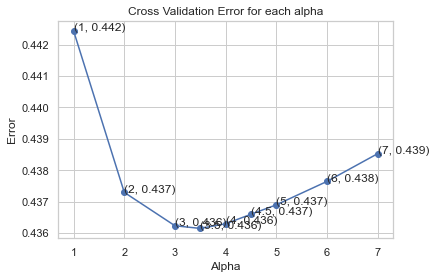

In [26]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge


alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7] 

cv_rmsle_array=[] 

for i in tqdm(alpha):
    model = Ridge(solver="sag", random_state=42, alpha=i)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_rmsle_array.append(sqrt(mse(y_cv, preds_cv)))

for i in range(len(cv_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',cv_rmsle_array[i])
    
best_alpha = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_rmsle_array)
ax.scatter(alpha, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [27]:
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=42, alpha=alpha[best_alpha])
model.fit(X_train, y_train)
ridge_preds_tr = model.predict(X_train)
ridge_preds_cv = model.predict(X_cv)

print('Train RMSLE:', sqrt(mse(y_train, ridge_preds_tr)))
 
print("Cross validation RMSLE: ", sqrt(mse(y_cv, ridge_preds_cv)))


Best alpha:  3.5
Train RMSLE: 0.376691052224983
Cross validation RMSLE:  0.43614341447637167


In [28]:
submission = pd.read_csv('sample_submission.csv')

ridge_preds_te = model.predict(X_test)

submission['price'] = ridge_preds_te

submission.to_csv('ridge_model.csv', index=False)


### 2. SVM Regression

#### Hyper parameter tuning using RandomizedSearchCV

RMSLE for C= 0.01 is 1.305164505733532
RMSLE for C= 0.03 is 1.2643218261140055
RMSLE for C= 0.1 is 1.171096454196885
RMSLE for C= 0.3 is 1.0562243960591806
RMSLE for C= 1 is 0.9711361763565276
RMSLE for C= 3 is 0.8659787697378741
RMSLE for C= 10 is 1.2096595752820591


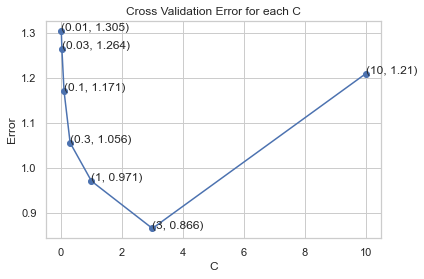

In [30]:
c_param = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
cv_rmsle_array=[]

for i in c_param:
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print('RMSLE for C=',i, 'is', cv_err)

best_C = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c_param, cv_rmsle_array)
ax.scatter(c_param, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

#### Training and testing using best parameters 

In [31]:
best_C = c_param[best_C]
print('Best C: ', best_C)
model = SVR(C=best_C, max_iter=200)
model.fit(X_train, y_train)

Best C:  3


SVR(C=3, max_iter=200)

In [32]:
svr_preds_tr = model.predict(X_train)

svr_preds_cv = model.predict(X_cv)

print('Train RMSLE:', sqrt(mse(y_train, svr_preds_tr)))

print("Cross validation RMSLE: ", sqrt(mse(y_cv, svr_preds_cv)))

Train RMSLE: 0.8558257457135766
Cross validation RMSLE:  0.8659787697378741


In [34]:
submission = pd.read_csv('sample_submission.csv')

svr_preds_cv = model.predict(X_test)

submission['price'] = svr_preds_cv

submission.to_csv('svm_model.csv', index=False)


### 3. RandomForest Regression

#### Hyper parameter tuning using RandomizedSearchCV

RMSLE for N=10 is 0.5157758825880991	 elapsed time:1:23:21.604008
RMSLE for N=20 is 0.5045719085993344	 elapsed time:4:12:50.361370


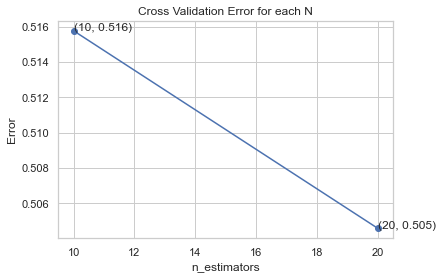

In [26]:
dt = datetime.datetime #to track time

estimators = [10, 20]
cv_rmsle_array=[]
t0 = dt.now()
for i in estimators:
    model = RandomForestRegressor(n_estimators=i, min_samples_split=10, max_features='sqrt', max_samples=0.9, random_state=42)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print (f'RMSLE for N={i} is {cv_err}\t elapsed time:{dt.now() - t0}')

best_N = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(estimators, cv_rmsle_array)
ax.scatter(estimators, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((estimators[i],np.round(txt,3)), (estimators[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each N")
plt.xlabel("n_estimators")
plt.ylabel("Error")
plt.show()

**Training RandomForest Regressor with higher values of n_estimators was taking tremendous amount of time without giving any results. Due to this reason, we have trained it with less number of estimators. The above code itself took approx. 3 hrs and hence, we did not train further.**

#### Training and testing using best parameters 

In [27]:
best_N = estimators[best_N]
print('Best n_estimators: ', best_N)
model = RandomForestRegressor(n_estimators=best_N, min_samples_split=10, max_features='sqrt', max_samples=0.9, random_state=42)
model.fit(X_train, y_train)

Best n_estimators:  20


RandomForestRegressor(max_features='sqrt', max_samples=0.9,
                      min_samples_split=10, n_estimators=20, random_state=42)

In [28]:
rf_preds_tr = model.predict(X_train)
rf_preds_cv = model.predict(X_cv)


print('Train RMSLE:', sqrt(mse(y_train, rf_preds_tr)))

print("Cross validation RMSLE: ", sqrt(mse(y_cv, rf_preds_cv)))

Train RMSLE: 0.28726248842446195
Cross validation RMSLE:  0.5045719085993344


In [29]:
submission = pd.read_csv('sample_submission.csv')

randomforest_preds_te = model.predict(X_test)

submission['price'] = randomforest_preds_te

submission.to_csv('randomforest_model.csv', index=False)


### 4. LightGBM Regression

#### Hyper parameter tuning using RandomizedSearchCV

In [28]:
from lightgbm import LGBMRegressor

lgb_model=LGBMRegressor()

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(300, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
         }


lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=4, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.3745401188473625, max_depth=14, min_child_weight=0.3668695797323276, n_estimators=1395, num_leaves=40
[CV 1/3; 1/4] END learning_rate=0.3745401188473625, max_depth=14, min_child_weight=0.3668695797323276, n_estimators=1395, num_leaves=40;, score=(train=-0.355, test=-0.435) total time=36.9min
[CV 2/3; 1/4] START learning_rate=0.3745401188473625, max_depth=14, min_child_weight=0.3668695797323276, n_estimators=1395, num_leaves=40
[CV 2/3; 1/4] END learning_rate=0.3745401188473625, max_depth=14, min_child_weight=0.3668695797323276, n_estimators=1395, num_leaves=40;, score=(train=-0.355, test=-0.433) total time=43.7min
[CV 3/3; 1/4] START learning_rate=0.3745401188473625, max_depth=14, min_child_weight=0.3668695797323276, n_estimators=1395, num_leaves=40
[CV 3/3; 1/4] END learning_rate=0.3745401188473625, max_depth=14, min_child_weight=0.3668695797323276, n_estimators=1395, num_leaves=40;, score=

In [29]:
df1 = pd.DataFrame(lgb_random.cv_results_)
#df1[['param_learning_rate', 'param_n_estimators', 'param_num_leaves', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'mean_train_score', 'mean_test_score']]

In [30]:
best_params = lgb_random.best_params_
print(best_params)

{'learning_rate': 0.3745401188473625, 'max_depth': 14, 'min_child_weight': 0.3668695797323276, 'n_estimators': 1395, 'num_leaves': 40}


#### Training and testing using best parameters 

In [31]:
model = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.3745401188473625, max_depth=14,
              min_child_weight=0.3668695797323276, n_estimators=1395,
              num_leaves=40, random_state=42, subsample=0.9)

In [32]:
lgb_preds_tr = model.predict(X_train)
lgb_preds_cv = model.predict(X_cv)


print('Train RMSLE:', sqrt(mse(y_train, lgb_preds_tr)))

print("Cross validation RMSLE: ", sqrt(mse(y_cv, lgb_preds_cv)))

Train RMSLE: 0.36759102761775614
Cross validation RMSLE:  0.43092987182318254


In [36]:
submission_df = pd.read_csv('sample_submission.csv')

lgb_preds_te = model.predict(X_test)

#submission_df['price'] = np.exp(lgb_preds_te) - 1

submission_df['price'] = lgb_preds_te

submission_df.to_csv('lgb_model.csv', index=False)


## Summary

In [2]:
from prettytable import PrettyTable

x=PrettyTable(["Model", "Train_RMSLE", "Validation_RMSLE"])

x.add_row(["Ridge",  "0.3766", "0.4361"])
x.add_row(["SVR",  "0.8558", "0.8659"])
x.add_row(["Random Forest",  "0.2872", "0.5045"])
x.add_row(["LightGBM", "0.3675", "0.4305"])

print(x)

+---------------+-------------+------------------+
|     Model     | Train_RMSLE | Validation_RMSLE |
+---------------+-------------+------------------+
|     Ridge     |    0.3766   |      0.4361      |
|      SVR      |    0.8558   |      0.8659      |
| Random Forest |    0.2872   |      0.5045      |
|    LightGBM   |    0.3675   |      0.4305      |
+---------------+-------------+------------------+


#### Conclusion
----------------

* Based on our analysis, we can see the best result we have got from LightGBM model, So we will consider it as our final model.